# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from PIL import ImageDraw
from tqdm.notebook import tqdm
import pickle 
from sklearn.utils import shuffle
import matplotlib.pylab as plt # plot module

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU is avalible.')
  print('Working on:', torch.cuda.get_device_name())
else:
  device = torch.device('cpu')
  print('GPU is not avalible.')
  print('Working on CPU')

GPU is not avalible.
Working on CPU


## Insecting data

train.csv

In [3]:
df = pd.read_csv('./C2_TrainDev/Test_mangoXYWH.csv')
df.head()

,image_id,x,y,w,h
0,39983.jpg,189,64,1078,793
1,12525.jpg,176,110,1067,818
2,22134.jpg,301,140,949,681
3,07679.jpg,300,45,868,652
4,25561.jpg,289,77,851,610


image

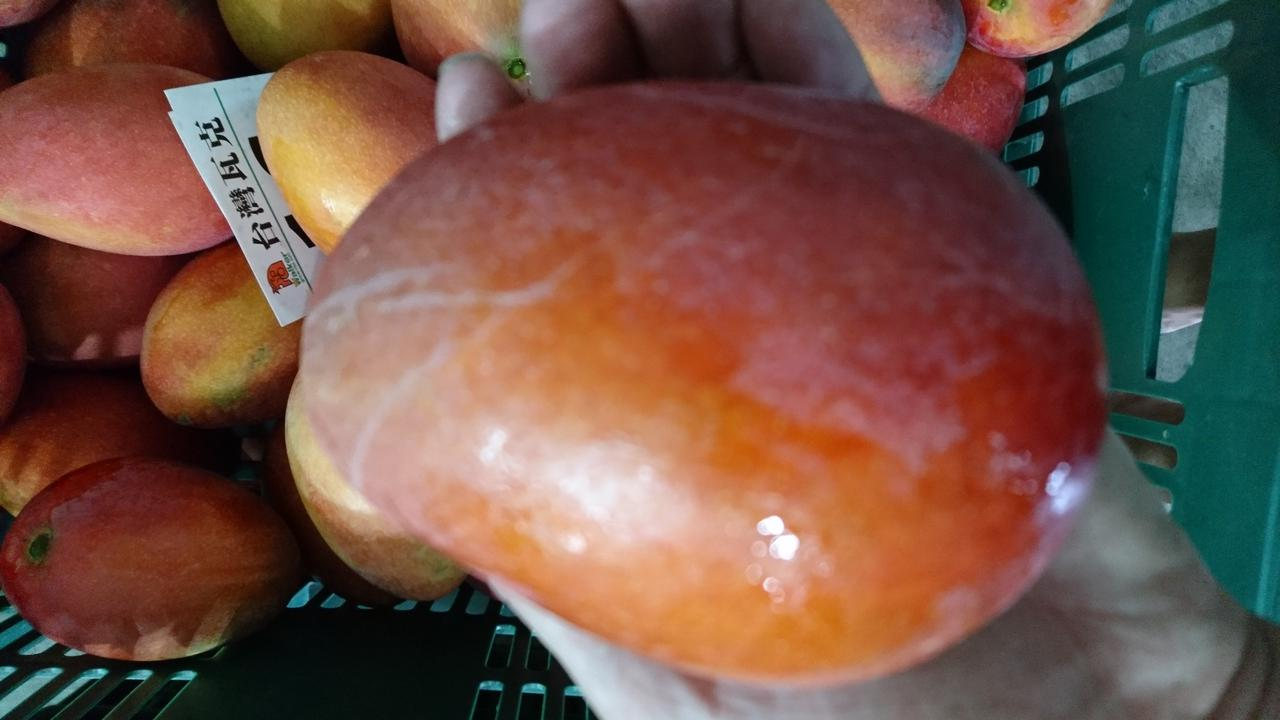

In [4]:
img = Image.open('./C2_TrainDev/Test/25561.jpg')
img

bbox

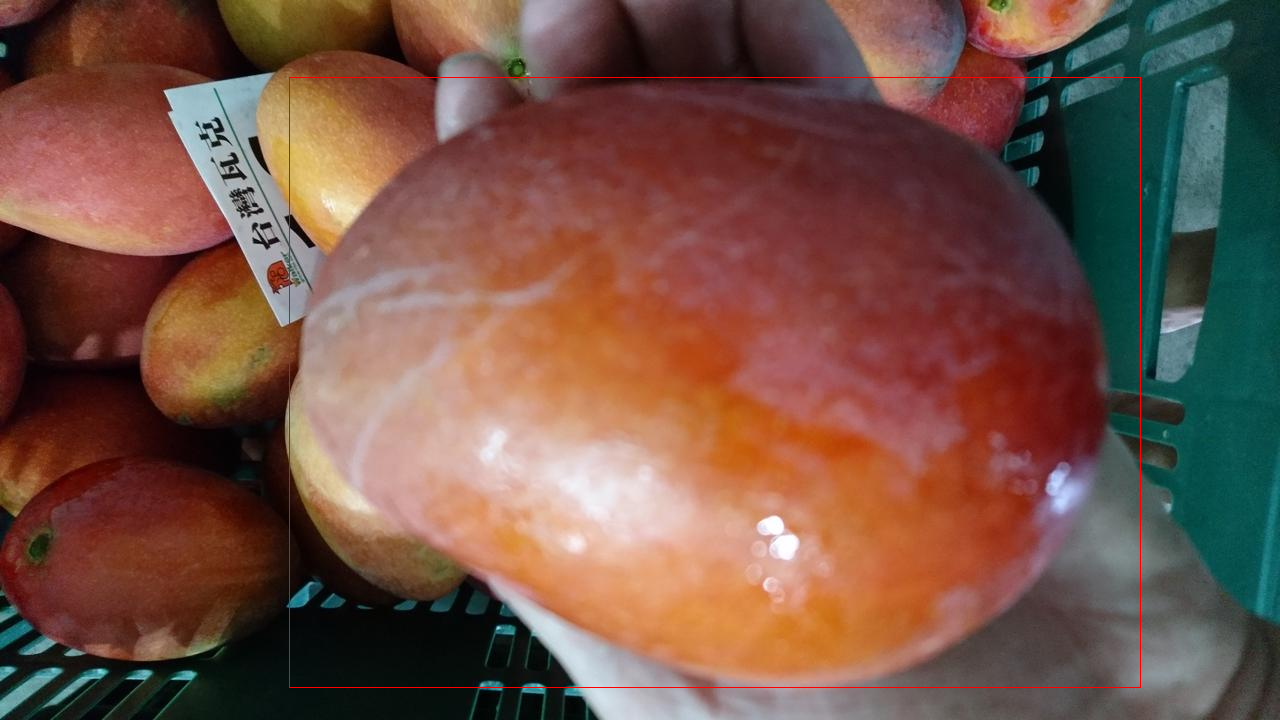

In [5]:
xmin = 289
ymin = 77
xmax = xmin+851
ymax = ymin+610
draw = ImageDraw.Draw(img)
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline ="red")
img

croped image

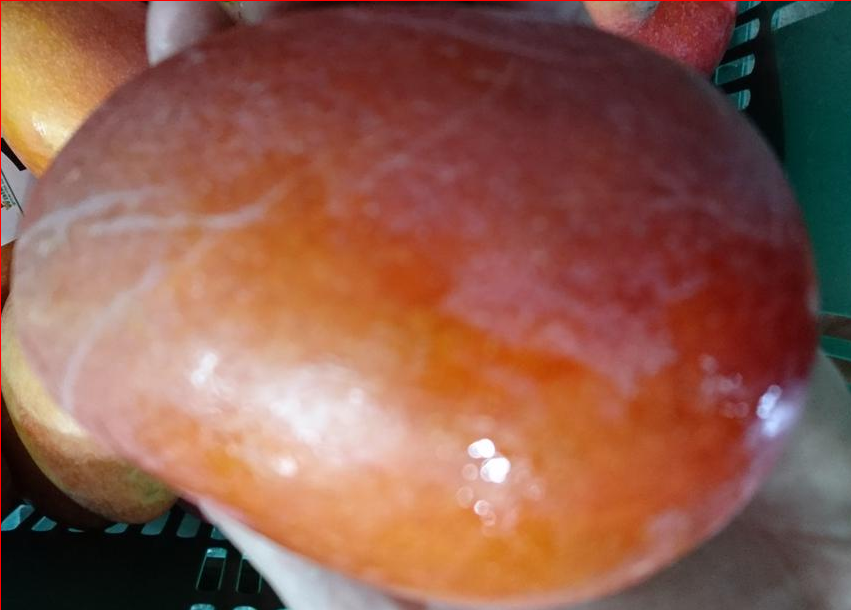

In [6]:
img2 = img.crop((xmin, ymin, xmax, ymax))
img2

## Building defect table

### test

In [7]:
import numpy as np
image=[]
xmin=[]
ymin=[]
xmax=[]
ymax=[]

with open(r'.\C2_TrainDev\Test_mangoXYWH.csv', 'r', encoding='utf-8-sig') as fh:
    for index,row in enumerate(fh):
        row=row.strip()
        row=row.split(',')
        if row[0] == 'image_id':
            continue 
            
        image.append(row[0])
        xmin.append(float(row[1]))
        ymin.append(float(row[2]))
        xmax.append(float(row[3])+float(row[1]))
        ymax.append(float(row[4])+float(row[2]))

print('image:' ,len(image))
print('xmin:' ,len(xmin))
print('ymin:' ,len(ymin))
print('xmax:' ,len(xmax))
print('ymax:' ,len(ymax))

image: 7363
xmin: 7363
ymin: 7363
xmax: 7363
ymax: 7363


In [8]:
testdf = pd.DataFrame({'image':image, 'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax  })
testdf

,image,xmin,ymin,xmax,ymax
0,39983.jpg,189.0,64.0,1267.0,857.0
1,12525.jpg,176.0,110.0,1243.0,928.0
2,22134.jpg,301.0,140.0,1250.0,821.0
3,07679.jpg,300.0,45.0,1168.0,697.0
4,25561.jpg,289.0,77.0,1140.0,687.0
...,...,...,...,...,...
7358,33011.jpg,19.0,111.0,576.0,548.0
7359,36756.jpg,368.0,30.0,822.0,362.0
7360,48839.jpg,25.0,133.0,513.0,564.0
7361,47534.jpg,149.0,66.0,1147.0,839.0


In [9]:
test_data = []

for idx,name in tqdm(enumerate(image)):
    img_path = './C2_TrainDev/Test/'+ name
    img = Image.open(img_path).convert("RGB")
    
    xmin_ = xmin[idx]
    ymin_ = ymin[idx]
    xmax_ = xmax[idx]
    ymax_ = ymax[idx]
    
    crop_img = img.crop((xmin_, ymin_, xmax_, ymax_))
    
    test_data.append(crop_img)

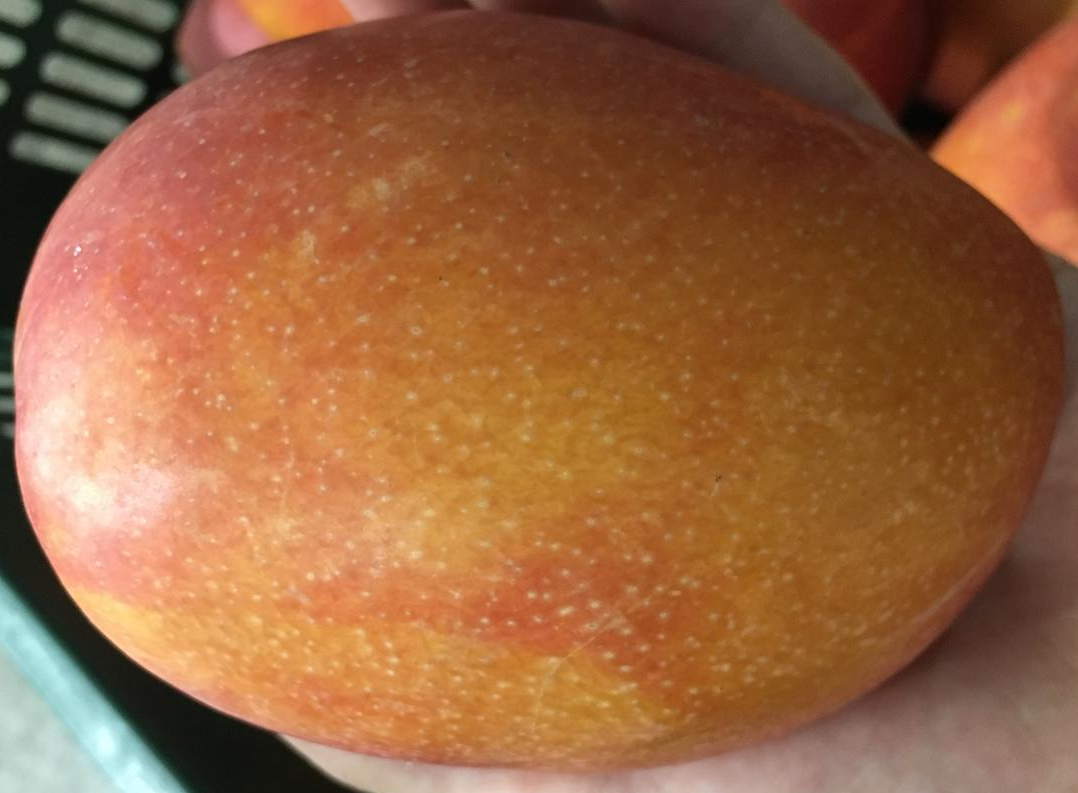

In [10]:
test_data[0]

## Pytorch VGG16、AlexNet

In [11]:
composed = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    #transforms.ToPILImage(),
])

Dataset

In [12]:
class Data(Dataset):
    def __init__(self, data, transforms=None):
        self.transforms = transforms
        self.data = data
    
    def __getitem__(self, idx):       
        img = self.data[idx]

        if self.transforms is not None:
            img = self.transforms(img)          

        return img

    def __len__(self):
        return len(self.data)

In [13]:
test_set = Data(data=test_data, transforms=composed )

In [14]:
test_set[0]

tensor([[[-2.1179,  0.3652,  0.3652,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179,  0.3309,  0.3823,  ..., -0.4226, -0.2856, -0.1143],
         [-2.1179,  0.0912,  0.2282,  ..., -0.4054, -0.2513, -0.0287],
         ...,
         [ 1.3413,  1.3242,  1.2899,  ...,  0.7419,  0.7248, -2.1179],
         [ 1.3413,  1.3070,  1.2557,  ...,  0.6906,  0.6734, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ...,  0.6221,  0.6221, -2.1179]],

        [[-2.0357,  0.7129,  0.7129,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357,  0.6779,  0.7304,  ..., -1.0553, -0.9678, -0.8102],
         [-2.0357,  0.4328,  0.5728,  ..., -1.0553, -0.9328, -0.7402],
         ...,
         [ 1.9034,  1.8859,  1.8508,  ...,  0.4153,  0.3803, -2.0357],
         [ 1.9034,  1.8683,  1.8158,  ...,  0.3627,  0.3277, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ...,  0.2927,  0.2752, -2.0357]],

        [[-1.8044,  0.5834,  0.5834,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044,  0.5485,  0.6008,  ..., -1

data loader

In [15]:
test_loader = DataLoader(test_set, batch_size=1)

model

In [16]:
class Net(nn.Module):   
    # Constructor
    def __init__(self):
        super(Net, self).__init__()
        self.alexnet = models.alexnet(pretrained=True)
        self.vgg16 = models.vgg16(pretrained=True)
    def forward(self, x):
        x1 = self.alexnet(x)
        x2 = self.vgg16(x)
        x = torch.cat((x1,x2),dim=1)
        return x

In [17]:
model = Net()
model.to(device);
model.eval();

## buliding feature list
過程需要約40分鐘

In [18]:
test_feature = []

for image in tqdm(test_loader):
    image = image.to(device)
    with torch.no_grad():
        out = model(image).to('cpu')
    test_feature.append(image)

In [19]:
test_feature[:5]

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

save to pickle

In [20]:
with open('./C2_TrainDev/processed_data/baseline_crop/test_feature.pkl', 'wb') as f:
  pickle.dump(test_feature, f)

load from pickle

In [4]:
with open('./C2_TrainDev/processed_data/baseline_crop/test_feature.pkl', 'rb') as f:
    train_feature = pickle.load(f)

In [21]:
print('len of test_feature:',len(test_feature))

len of test_feature: 7363
